In [5]:
import os
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet50(pretrained=True)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).to(device)
feature_extractor.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [6]:
def list_images(folder):
    exts = [".jpg", ".png", ".jpeg", ".bmp"]
    files = []
    for root, dirs, names in os.walk(folder):
        for n in names:
            if any(n.lower().endswith(e) for e in exts):
                files.append(os.path.join(root, n))
    return files

train_root = "./Training"
test_root  = "./Testing"

classes = os.listdir(train_root)

train_imgs = {cls: list_images(os.path.join(train_root, cls)) for cls in classes}
test_imgs  = {cls: list_images(os.path.join(test_root, cls)) for cls in classes}


In [7]:
def extract_feature(path):
    img = Image.open(path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = feature_extractor(x)
    return feat.flatten()

train_features = {}
for cls in classes:
    train_features[cls] = []
    for path in train_imgs[cls]:
        train_features[cls].append(extract_feature(path))

threshold = 0.95
class_counts = {cls: [] for cls in classes}

for cls in classes:
    print("\n", cls)
    for test_path in test_imgs[cls]:
        test_feat = extract_feature(test_path)
        count = 0
        for train_feat in train_features[cls]:
            score = torch.nn.functional.cosine_similarity(test_feat, train_feat, dim=0).item()
            if score >= threshold:
                count += 1
        class_counts[cls].append(count)
        print(test_path, "->", count)



 glioma
./Testing\glioma\Te-glTr_0000.jpg -> 1
./Testing\glioma\Te-glTr_0001.jpg -> 1
./Testing\glioma\Te-glTr_0002.jpg -> 3
./Testing\glioma\Te-glTr_0003.jpg -> 0
./Testing\glioma\Te-glTr_0004.jpg -> 1
./Testing\glioma\Te-glTr_0005.jpg -> 2
./Testing\glioma\Te-glTr_0006.jpg -> 0
./Testing\glioma\Te-glTr_0007.jpg -> 1
./Testing\glioma\Te-glTr_0008.jpg -> 1
./Testing\glioma\Te-glTr_0009.jpg -> 3
./Testing\glioma\Te-gl_0010.jpg -> 0
./Testing\glioma\Te-gl_0011.jpg -> 1
./Testing\glioma\Te-gl_0012.jpg -> 1
./Testing\glioma\Te-gl_0013.jpg -> 0
./Testing\glioma\Te-gl_0014.jpg -> 6
./Testing\glioma\Te-gl_0015.jpg -> 1
./Testing\glioma\Te-gl_0016.jpg -> 6
./Testing\glioma\Te-gl_0017.jpg -> 1
./Testing\glioma\Te-gl_0018.jpg -> 4
./Testing\glioma\Te-gl_0019.jpg -> 3
./Testing\glioma\Te-gl_0020.jpg -> 0
./Testing\glioma\Te-gl_0021.jpg -> 0
./Testing\glioma\Te-gl_0022.jpg -> 2
./Testing\glioma\Te-gl_0023.jpg -> 0
./Testing\glioma\Te-gl_0024.jpg -> 0
./Testing\glioma\Te-gl_0025.jpg -> 8
./Testing

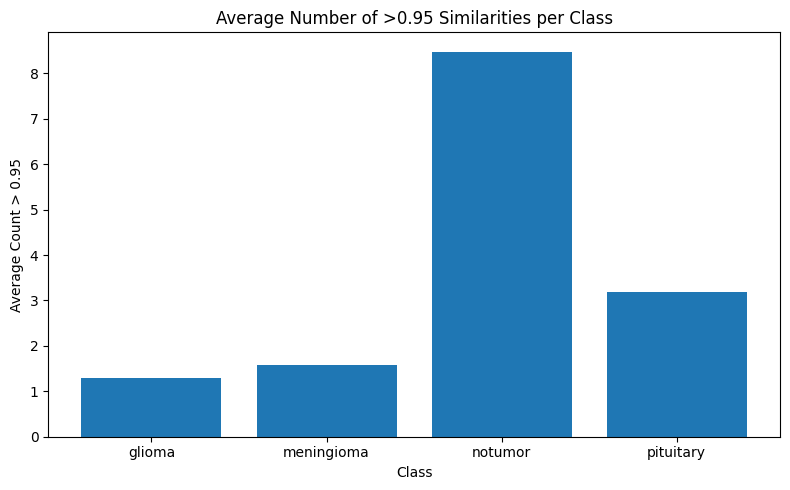

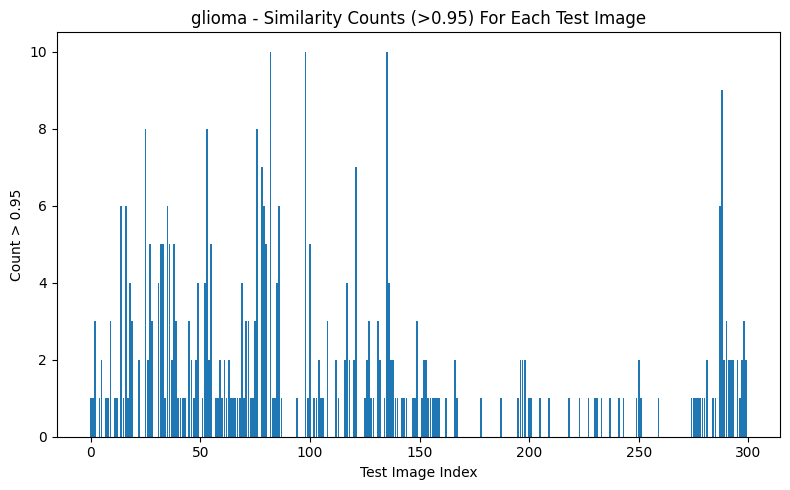

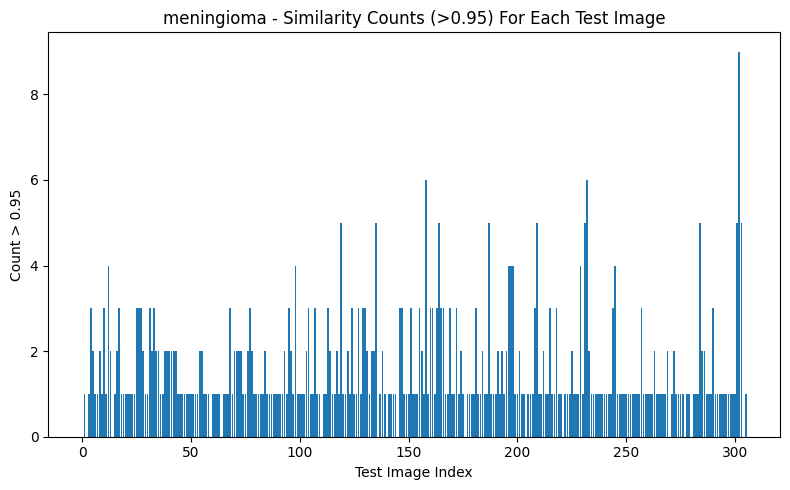

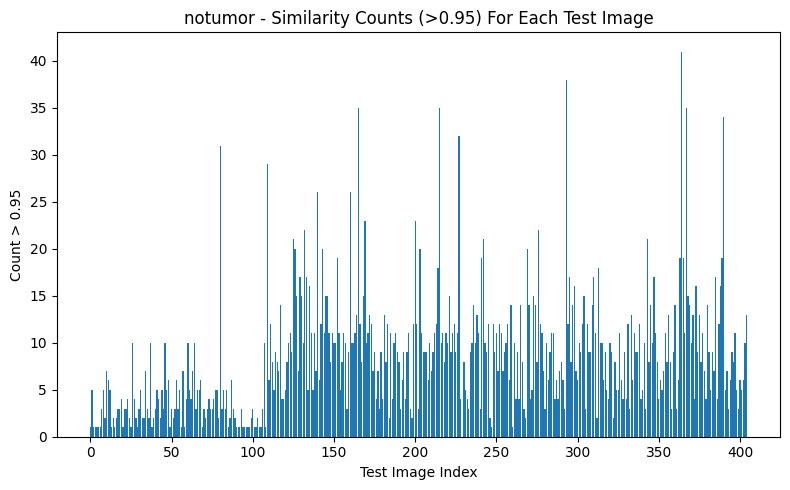

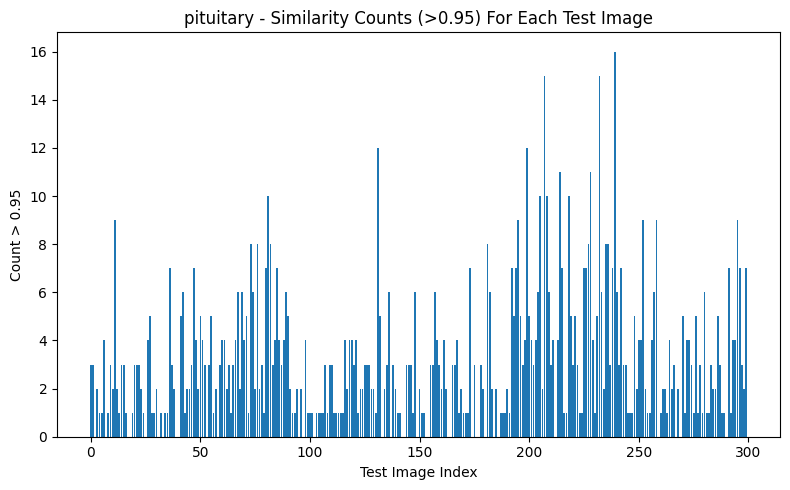

In [8]:
avg_counts = {
    cls: (sum(vals)/len(vals) if len(vals) > 0 else 0)
    for cls, vals in class_counts.items()
}

plt.figure(figsize=(8,5))
plt.bar(avg_counts.keys(), avg_counts.values())
plt.title("Average Number of >0.95 Similarities per Class")
plt.xlabel("Class")
plt.ylabel("Average Count > 0.95")
plt.tight_layout()
plt.show()
for cls in classes:
    plt.figure(figsize=(8,5))
    plt.bar(range(len(class_counts[cls])), class_counts[cls])
    plt.title(f"{cls} - Similarity Counts (>0.95) For Each Test Image")
    plt.xlabel("Test Image Index")
    plt.ylabel("Count > 0.95")
    plt.tight_layout()
    plt.show()

